## Pre-trained word embeddings: exercise YELP

Yelp is a review website (see e.g. https://nl.yelp.be/search?find_desc=&find_loc=gent&ns=1)

- The file yelp_labelled.txt contains reviews. 
- If Label = 0, it's a review with a negative sentiment. 
- If Label = 1, it's a review with a positive sentiment. 

Create an ANN model that predicts the sentiment.

Filter out those reviews that aren't in English first.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D,  MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model


import nltk


2.8.0


In [2]:
# helper functions for visualisation
# plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/yelp_labelled.txt",sep="\t") 
data.head()


,Text,Label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Show the statistical information about the data.

In [4]:
data.describe()

,Label
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


Is this a skewed dataset?

In [5]:
data['Label'].value_counts()

1    500
0    500
Name: Label, dtype: int64

In [6]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print ('You are running on Google Colab')
    !pip install langdetect
else:
    colab = False
    print ('You are not running on Google Colab')

You are not running on Google Colab


Remove those Text's that are not in English.

In [7]:
from langdetect import detect
data['Lang'] = data['Text'].apply(detect)
data[data['Lang'] != 'en']

,Text,Label,Lang
19,did not like at all.,0,af
88,Omelets are to die for!,1,af
93,Best breakfast buffet!!!,1,no
94,say bye bye to your tip lady!,0,tl
109,Sooooo good!!,1,so
117,I've had better atmosphere.,0,no
131,Penne vodka excellent!,1,fr
133,The management is rude.,0,nl
140,Don't do it!!!!,0,nl
163,Avoid at all cost!,0,ca


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1000 non-null   object
 1   Label   1000 non-null   int64 
 2   Lang    1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [9]:
data = data[data['Lang'] == 'en']
data.head()

,Text,Label,Lang
0,Wow... Loved this place.,1,en
1,Crust is not good.,0,en
2,Not tasty and the texture was just nasty.,0,en
3,Stopped by during the late May bank holiday of...,1,en
4,The selection on the menu was great and so wer...,1,en


How many records are left?

In [10]:
data.count()

Text     963
Label    963
Lang     963
dtype: int64

## Using pre-trained word embeddings

What is the average length of the Text's (expressed as a number of words). This will be important when we need to truncate the sequences to a maximum length?  
75% of the blogs consist of how many words?

In [11]:
from nltk.tokenize import word_tokenize
data["numberOfWords"] = data["Text"].str.split().map(len)
data.head()

,Text,Label,Lang,numberOfWords
0,Wow... Loved this place.,1,en,4
1,Crust is not good.,0,en,4
2,Not tasty and the texture was just nasty.,0,en,8
3,Stopped by during the late May bank holiday of...,1,en,15
4,The selection on the menu was great and so wer...,1,en,12


In [12]:
data['numberOfWords'].describe()

count    963.000000
mean      11.152648
std        6.221698
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       32.000000
Name: numberOfWords, dtype: float64

What is X_train, y_train, X_test, y_test?

In [13]:
# Extract a training & validation split
from sklearn.model_selection import train_test_split
X = data.drop(['Lang','Label','numberOfWords'],axis=1)
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42)

What is X_train, y_train, X_val, y_val?

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

What are the dimensions of X_train, X_val, X_test, y_train, y_val, y_test?

In [15]:
print("Shape of x_train:", X_train.shape)
print("Shape of x_test:", X_test.shape)
print("Shape of x_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (616, 1)
Shape of x_test: (193, 1)
Shape of x_val: (154, 1)
Shape of y_train: (616,)
Shape of y_test: (193,)
Shape of y_val: (154,)


Transform X_train, X_val and X_test into an array

In [16]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)

print('X_train shape:', X_train.shape)
print(type(X_train))

X_train shape: (616, 1)
<class 'numpy.ndarray'>


### Create a vocabulary index

Use the TextVectorization to index the vocabulary found in the dataset. Later, the same layer instance will be used to vectorize the samples.

The layer will only consider the top 20,000 words, and will truncate or pad sequences to be actually 15 tokens long (75% quartile).

In [17]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=15)
text_ds = tf.data.Dataset.from_tensor_slices(X_train)
vectorizer.adapt(text_ds)


You can retrieve the computed vocabulary used via vectorizer.get_vocabulary().  
Let's print the top 5 words

In [18]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'was']

Vectorize a small sentence "the girl was unhappy" 

In [19]:
output = vectorizer([["i saw the girl was unhappy"]])
output.numpy()[0, :8]

array([5, 1, 2, 1, 4, 1, 0, 0], dtype=int64)

By which number is i represented? And girl? 
Give the dict mapping words to their indices.

In [20]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [21]:
print(word_index.get('i','key not found'))
print(word_index.get('girl','key not found'))

5
key not found


### Load pre-trained word embeddings


Make a dict mapping words (strings) to their NumPy vector representation. Use the 100-dimensional vectors.

In [22]:
# we compute an index mapping words to known embeddings
# by parsing the data dump of pre-trained embeddings:

if colab: 
  path_to_glove_file = '/content/gdrive/My Drive/glove.6B.100d.txt'
else:
  path_to_glove_file = 'datasets/glove.6B.100d.txt'

embeddings_index = {}

with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


What is the embeddings_vector for the word girl?

In [23]:
print(embeddings_index['girl'])

[ 7.4582e-01  1.9531e-01  4.6831e-01 -1.0277e-01 -2.9927e-01  9.9653e-01
  1.3940e-01  6.4173e-01  3.3129e-01  3.5322e-01 -3.0205e-01  3.4699e-01
  5.3364e-01  6.2235e-01  4.3555e-01  5.4403e-01  3.9656e-01 -3.1789e-01
 -2.0172e-01  9.9636e-01  1.8479e-03 -1.4826e-01 -4.1845e-03  2.4953e-01
  3.0177e-01  1.0043e+00 -4.4867e-01 -1.2911e+00 -1.2741e-01  9.0103e-01
  1.1870e-01  2.7229e-01  9.7697e-01  1.9520e-02  4.0453e-01 -6.1585e-01
 -5.0483e-01 -3.1174e-02  7.0384e-01 -4.6058e-01 -4.3899e-01  4.2115e-01
 -1.7343e-01 -4.1879e-01  7.4560e-03  2.6609e-01 -7.8183e-01  4.5464e-01
  9.0846e-01 -1.3126e-01 -4.8101e-01 -2.4726e-01  2.9251e-01  1.4122e+00
  2.5368e-02 -1.9882e+00 -5.3257e-01  1.3427e-01  8.8987e-01  6.7416e-01
  7.3902e-01  1.0998e+00 -7.6633e-01 -8.4833e-04  5.0982e-01  1.9587e-01
  7.1845e-01  2.5045e-01 -2.9609e-01  1.9005e-01  1.9021e-01 -2.1668e-01
 -2.5819e-01  4.5417e-01  1.5185e-01  1.3500e+00  3.2284e-01 -2.3826e-01
 -6.9976e-01 -9.8157e-01 -3.9336e-01  5.2666e-01  6

Prepare a corresponding embedding matrix that can be ued in a Keras Embedding layer. It's a simple NumPy matrix where the entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [24]:
num_tokens = len(voc) + 2
# each word is represented by a vector of 100 floats (glove.6B.100d.txt)
embedding_dim = 100
hits = 0
misses = 0
missed_words = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# word_index is a dictionary that maps each word to an index
# we loop through all the words of word_index.items()
for word, i in word_index.items():
# we try to retrieve the vector of 100 floats for this word out of embeddings_index  
    embedding_vector = embeddings_index.get(word)
# if we found the corresponding vector of 100 floats    
    if embedding_vector is not None:
      # we put the vector on position i of embedding_matrix
        embedding_matrix[i] = embedding_vector
        hits += 1    
    else:
      # Words not found in embedding index will be all-zeros.    
        misses += 1
        missed_words.append(word)
        
print("Converted %d words (%d misses)" % (hits, misses))

print("*** Missed words = words not in word_index ***")
print(missed_words[0:10])
print()


Converted 1479 words (66 misses)
*** Missed words = words not in word_index ***
['', '[UNK]', 'delish', 'yelpers', 'yaall', 'workingeating', 'wayyy', 'vinegrette', 'veggitarian', 'veganveggie']



### Build the model
First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

In [25]:
X_train_final = vectorizer(np.array([s for s in X_train])).numpy()
X_val_final =  vectorizer(np.array([s for s in X_val])).numpy()
X_test_final = vectorizer(np.array([s for s in X_test])).numpy()

y_train_final = np.array(y_train)
y_val_final = np.array(y_val)
y_test_final = np.array(y_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)
print(y_train_final.shape)
print(y_val_final.shape)
print(y_test_final.shape)

(616, 1)
(154, 1)
(193, 1)
(616, 15)
(154, 15)
(193, 15)
(616,)
(154,)
(193,)


In [26]:
print(X_train_final[:5])

[[   5   49   14  347    0    0    0    0    0    0    0    0    0    0
     0]
 [  45   27 1185  381   26   40  187    0    0    0    0    0    0    0
     0]
 [  50  192  343    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1359    8   14   15    0    0    0    0    0    0    0    0    0    0
     0]
 [ 965   10   18    3  240    0    0    0    0    0    0    0    0    0
     0]]


Create a small ANN model to predict the Label. Load the pre-trained word embeddings matrix into an Embedding layer.

Compile the model.

Train the model.

Evaluate the model

In [27]:
num_classes = 2

def initial_model():
    # we create a variable called model, and we set it equal to an instance of a Sequential object.
    model = Sequential()

    model.add(Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=15,embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False))
    model.add(keras.layers.Flatten(input_shape=[num_tokens, embedding_dim]))

    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(Dense(num_classes, activation='softmax'))


    # Before we can train our model, we must compile it
    # To the compile() function, we are passing the optimizer, the loss function, and the metrics that we would like to see. 
    # Notice that the optimizer we have specified is called Adam. Adam is just a variant of SGD. 
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01),
                  metrics=['accuracy']) 
    return model

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = initial_model()

batch_size = 64
epochs = 10

early_stopping_cb = keras.callbacks.EarlyStopping(patience=1,
                                                  restore_best_weights=True)

history = model.fit(X_train_final, y_train_final,epochs=20, batch_size=32, 
                    validation_data=(X_val_final,y_val_final),
                    callbacks=[early_stopping_cb])

Epoch 1/20
20/20 [==============================] - 1s 12ms/step - loss: 2.6401 - accuracy: 0.4838 - val_loss: 0.7730 - val_accuracy: 0.5519
Epoch 2/20
20/20 [==============================] - 0s 7ms/step - loss: 1.1332 - accuracy: 0.4968 - val_loss: 0.7377 - val_accuracy: 0.4610
Epoch 3/20
20/20 [==============================] - 0s 7ms/step - loss: 0.7770 - accuracy: 0.5195 - val_loss: 0.6975 - val_accuracy: 0.4740
Epoch 4/20
20/20 [==============================] - 0s 7ms/step - loss: 0.7444 - accuracy: 0.5373 - val_loss: 0.6878 - val_accuracy: 0.5519
Epoch 5/20
20/20 [==============================] - 0s 6ms/step - loss: 0.7488 - accuracy: 0.5016 - val_loss: 0.6726 - val_accuracy: 0.5844
Epoch 6/20
20/20 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.5519 - val_loss: 0.7178 - val_accuracy: 0.5195


Training set Accuracy:   0.67
Training set Loss: 0.6406

Validation set Accuracy:   0.58
Validation set Loss: 0.6726



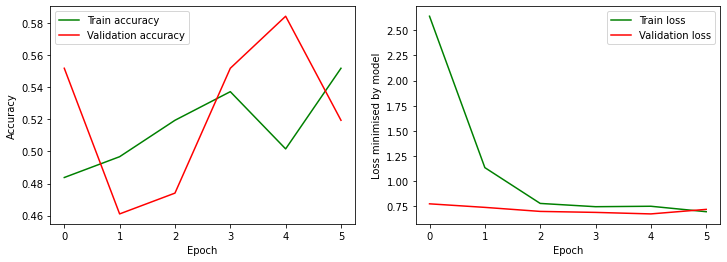

In [29]:
[train_loss, train_accuracy] = model.evaluate(X_train_final, y_train_final, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(X_val_final, y_val_final, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history)

Use your model to predict the sentiment of a review .

In [30]:
good = "For sure the best restaurant in town!"

X_good = vectorizer(np.array([s for s in [good]])).numpy()
pred = model.predict([X_good])
print(pred)



[[0.44999403 0.55000603]]
